# No dimensionality reduction - Stacking
- This notebook will explore the **Stacking** ensemble technique, different base models along with different architectures will be tested looking for an optimal configuration. In this case, the Dataset **without dimensionality reduction** will be used. In other words, all the features of the original dataset are going to be used.
- All data has been previously processed and normalized in the notebook `data_expl_and_preproc.ipynb`.

## Authors
- Izquierdo Alvarez, Mario
- Giménez López, Antonio
- Romero Romero, Martín
- Nunez Sánchez, Fernando 

## Enviroment configuration
- Firstly, the needed packages along with our custom Modules are loaded. Additionally, a `Random.seed()` is set for reproducibility.

In [1]:
using Random
using Statistics
# Including Modules
push!(LOAD_PATH, "../modules")

#Random seed for reproducibility
seed = 42
Random.seed!(seed)

TaskLocalRNG()

In [ ]:
using HDF5
using Preprocessing
using ModelSelection
using Plotting
using Sk_Modeling
using Flux

## Loading data
- The only preprocessing applied to the data was a Min-Max normalization.

In [3]:
file = h5open("ndr_data.h5", "r")
train_input = read(file, "train_input")
train_tags = read(file, "train_tags")
close(file)

In [4]:
# As the ensemble function handles different models, to work properly with all of them, the tags must be passed as a matrix of Ints
train_tags = map(x -> parse(Int,x), train_tags);

## 10-Fold Cross-Validation

The cross-validation technique is applied to get the performance estimation of the different models. 

In this process, we have tested several configurations trying to approximate an optimal one.

To face this problem, all base models that will be used (ANN, SVM, KNN and Decision Trees) have been tested previously in an individual manner. 

In general scenarios, Stacking is beneficed of the variability between the base models. Thus, we will test this stacking configurations with three base models, living one out. 

As an example, a first approach might be using **Decision Tree**, **SVM**, and **ANN** as the three base models, leaving out the **KNN**. All the base models will use the hyperparameter configuration that have previously demonstrated a major performance.

Finally, all the models will be joined together in a single stacking ensemble and it will be compared to the previous models.

In [5]:
model = :Stacking
# Params for cross validation
N = size(train_input, 1)
k = 10

kFoldIndices = crossvalidation(N,k);
best_models_acc = [];

In [6]:
# Defining the base models of the different staking models
estimators = [
    [:DecisionTree, :KNN, :SVM], # Leave out ANN
    [:DecisionTree, :KNN, :ANN], # Leave out SVM
    [:DecisionTree, :ANN, :SVM], # Leave out KNN
    [:ANN, :KNN, :SVM],          # Leave out DecisionTree
]
hyperparameters = [];

In [7]:
# Compute the inverse of the cov matrix for KNN with mahalanobis distance
cov_matrix = cov(train_input, dims=1)
inv_cov_matrix = inv(cov_matrix)
# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem
stacking_1 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed) # SVM params
    
]
stacking_2 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
]
stacking_3 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed) # SVM params
]
stacking_4 = [
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed) # SVM params
]
push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);
push!(hyperparameters, stacking_3);
push!(hyperparameters, stacking_4);

In [8]:
# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4

----- acc means -----
Hyperparams set 2 -> 0.966 ± 0.015
Hyperparams set 1 -> 0.958 ± 0.013
Hyperparams set 3 -> 0.958 ± 0.013
Hyperparams set 4 -> 0.958 ± 0.013

----- sensitivity means -----
Hyperparams set 2 -> 0.966 ± 0.015
Hyperparams set 1 -> 0.958 ± 0.013
Hyperparams set 3 -> 0.958 ± 0.013
Hyperparams set 4 -> 0.958 ± 0.013

----- specificity means -----
Hyperparams set 2 -> 0.989 ± 0.005
Hyperparams set 1 -> 0.986 ± 0.005
Hyperparams set 3 -> 0.986 ± 0.005
Hyperparams set 4 -> 0.986 ± 0.005

----- ppv means -----
Hyperparams set 2 -> 0.968 ± 0.015
Hyperparams set 1 -> 0.959 ± 0.013
Hyperparams set 3 -> 0.959 ± 0.013
Hyperparams set 4 -> 0.959 ± 0.013

----- npv means -----
Hyperparams set 2 -> 0.988 ± 0.005
Hyperparams set 1 -> 0.985 ± 0.005
Hyperparams set 3 -> 0.985 ± 0.005
Hyperparams set 4 -> 0.985 ± 0.005

----- f_scor

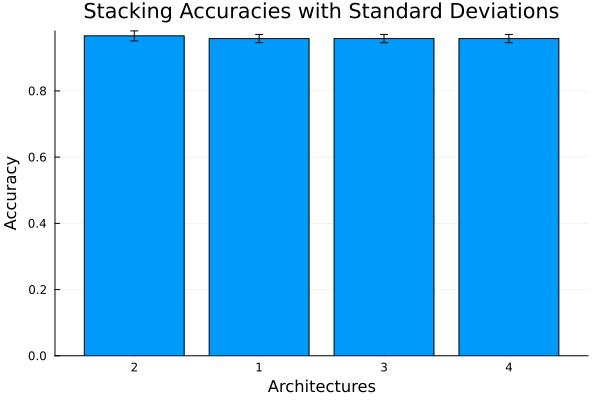

In [9]:
plot_acc_comparison(model, all_metrics)

## Discussion
The observed results are quite good, as expected. However, what is surprising is that the best model was not the one excluding KNN, which individually yielded the poorest results. This could highlight the importance of diversity in base models, aided by the weighting performed by the meta-model, in this case, an SVM.

It's noteworthy that, unlike the rest of the models that had been individually tested, the MLP had not been evaluated separately, as `Flux` was used previously for implementing ANNs. However, in this ensemble context, the `MLPClassifier` from `scikit-learn` has been used. This allows for the exploration of additional configurations; in this case, we will test the inclusion of an adaptive learning rate. The introduction of an adaptive learning rate could potentially improve the model's ability to fine-tune its learning process, adjusting the rate based on the model's performance and progression, which might lead to better overall ensemble model performance.

In [10]:
estimators = [
    [:DecisionTree, :KNN, :ANN], # Leave out SVM
    [:DecisionTree, :ANN, :SVM], # Leave out KNN
    [:ANN, :KNN, :SVM],          # Leave out DecisionTree
]
hyperparameters = [];

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem

stacking_1 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed, :learning_rate => "adaptive") # ANN params
]
stacking_2 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed, :learning_rate => "adaptive"), # ANN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed) # SVM params
]
stacking_3 = [
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed, :learning_rate => "adaptive"), # ANN params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed) # SVM params
]
push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);
push!(hyperparameters, stacking_3);


all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3

----- acc means -----
Hyperparams set 1 -> 0.966 ± 0.015
Hyperparams set 2 -> 0.958 ± 0.013
Hyperparams set 3 -> 0.958 ± 0.013

----- sensitivity means -----
Hyperparams set 1 -> 0.966 ± 0.015
Hyperparams set 2 -> 0.958 ± 0.013
Hyperparams set 3 -> 0.958 ± 0.013

----- specificity means -----
Hyperparams set 1 -> 0.989 ± 0.005
Hyperparams set 2 -> 0.986 ± 0.005
Hyperparams set 3 -> 0.986 ± 0.005

----- ppv means -----
Hyperparams set 1 -> 0.968 ± 0.015
Hyperparams set 2 -> 0.959 ± 0.013
Hyperparams set 3 -> 0.959 ± 0.013

----- npv means -----
Hyperparams set 1 -> 0.988 ± 0.005
Hyperparams set 2 -> 0.985 ± 0.005
Hyperparams set 3 -> 0.985 ± 0.005

----- f_score means -----
Hyperparams set 1 -> 0.966 ± 0.015
Hyperparams set 2 -> 0.958 ± 0.013
Hyperparams set 3 -> 0.958 ± 0.013

----- err_rate -----
Hyperparams set 1 -> 0.034 ± 0.015
Hyperparams set 2 -> 0.042 ± 0.013
Hyp

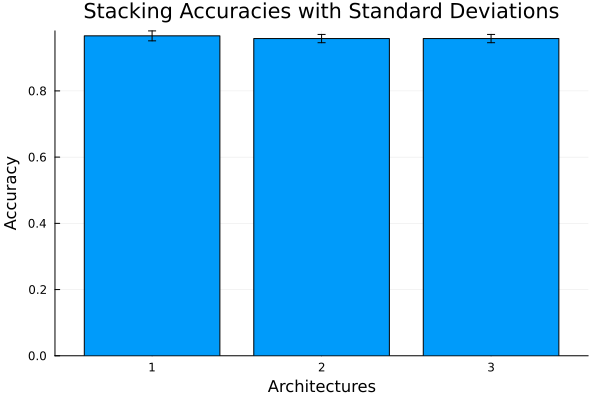

In [11]:
plot_acc_comparison(model, all_metrics)

### Discussion

No significant difference is observed with the addition of an adaptive learning rate. The stacking model yielding the best results continues to be the one excluding the SVM. Finally, two more tests will be conducted: one creating a stacking model that uses all the base models with the best configurations found, and another that employs very simple classifiers, with the aim of determining if combining them yields an acceptable accuracy rate.

This approach will provide insights into the effectiveness of ensemble techniques in different scenarios. The first test will determine if a comprehensive combination of all previously successful models enhances performance through diversity and strength in numbers. The second test, using simpler classifiers, will explore whether a combination of less complex models can achieve comparable accuracy through the ensemble effect.

In [12]:
estimators = [
    [:DecisionTree, :ANN, :SVM, :KNN], # All in
    [:DecisionTree, :ANN, :SVM, :KNN] # All in simple models
]
hyperparameters = [];

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem

stacking_1 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed, :learning_rate => "adaptive"), # ANN params
    Dict(:kernel => "linear", :C => 10.0, :random_state => seed), # SVM params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance") # KNN params
]
stacking_2 = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (16,), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 20, :max_iter => 1000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:kernel => "linear", :C => 5.0, :random_state => seed), # SVM params
    Dict(:n_neighbors => 10, :weights => "uniform") # KNN params
]

push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);

all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2

----- acc means -----
Hyperparams set 1 -> 0.958 ± 0.013
Hyperparams set 2 -> 0.952 ± 0.013

----- sensitivity means -----
Hyperparams set 1 -> 0.958 ± 0.013
Hyperparams set 2 -> 0.952 ± 0.013

----- specificity means -----
Hyperparams set 1 -> 0.986 ± 0.005
Hyperparams set 2 -> 0.984 ± 0.005

----- ppv means -----
Hyperparams set 1 -> 0.959 ± 0.013
Hyperparams set 2 -> 0.954 ± 0.013

----- npv means -----
Hyperparams set 1 -> 0.985 ± 0.005
Hyperparams set 2 -> 0.983 ± 0.004

----- f_score means -----
Hyperparams set 1 -> 0.958 ± 0.013
Hyperparams set 2 -> 0.953 ± 0.013

----- err_rate -----
Hyperparams set 1 -> 0.042 ± 0.013
Hyperparams set 2 -> 0.048 ± 0.013


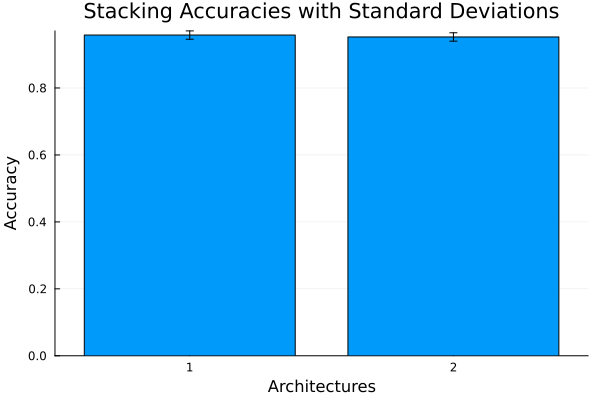

In [13]:
plot_acc_comparison(model, all_metrics)

### Discussion
It is observed that while neither of these models has been the best in terms of accuracy, both yield very good results. Furthermore, it is noteworthy that the second model, which utilizes notably simpler base models, offers a performance very close to the best model obtained. This demonstrates the significant potential of ensemble methods.

The success of the simpler model in particular highlights how ensemble techniques can leverage the strengths of individual, even basic, models to achieve robust overall performance.

## Final discussion

Finally, the best model is obtained in the first experiment, with the optimal hyperparameter configuration found at individual experiments and the following base estimators:

1. **Decision Tree**
2. **k-Nearest neighbors**
3. **Artificial neural network**

This results in an accuracy of **0.966 ± 0.015**. Once again, It is also remarkable the high performance of the ensemble with simple base models. It's noteworthy that using this sort of ensemble might be better, since the computational complexity can be significantly lower while risking very little in terms of accuracy.

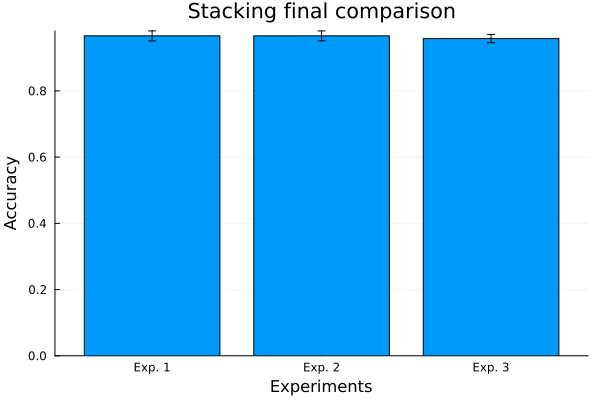

In [15]:
plot_final_comparison("Stacking final comparison", best_models_acc)